In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
from fastai.vision.all import *
from fastai.distributed import *

import fastai
import sklearn.metrics as skm

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', None)

import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2
import scipy.io as sio
import h5py


## Test classification model in TCGA CRC in MSS vs MSI


In [3]:
Path('TCGA').ls()

(#10) [Path('TCGA/SVS'),Path('TCGA/merged_TCGA_TUM_clini_table_v1.xlsx'),Path('TCGA/merged_TCGA_TUM_slide_table_v1.xlsx'),Path('TCGA/TCGA_MSI-H.csv'),Path('TCGA/TCGA_MSI-L.csv'),Path('TCGA/TCGA_MSS.csv'),Path('TCGA/MSI-H_project'),Path('TCGA/MSI-L_project'),Path('TCGA/MSS_project'),Path('TCGA/TILES')]

In [4]:
cx = pd.read_excel('TCGA/merged_TCGA_TUM_clini_table_v1.xlsx', index_col=0)

In [5]:
slide = pd.read_excel('TCGA/merged_TCGA_TUM_slide_table_v1.xlsx', index_col=0)

In [10]:
cx.loc[cx.submitter_id == 'TCGA-EI-6507'].MSIStatus

case_id
c3f0608b-d493-4c74-930a-d7998a48a659    MSI-H
Name: MSIStatus, dtype: object

In [5]:
#blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.png' Case = TCGA-CM-4746 , Sample = 01Z, Portion = 00, Slide = 00-DX1
slide.head(1)

,slide_submitter_id,case_id,case_submitter_id,project_id,sample_id,sample_submitter_id,portion_id,portion_submitter_id,percent_tumor_nuclei,percent_normal_cells,percent_lymphocyte_infiltration,percent_neutrophil_infiltration,section_location,percent_necrosis,percent_stromal_cells,percent_tumor_cells
slide_id,,,,,,,,,,,,,,,,
da7fa2a0-e690-4593-a4e1-a3bba3c294ed,TCGA-DM-A1D7-01A-01-TSA,fac2c617-8149-45bb-b766-fbe13dc3c425,TCGA-DM-A1D7,TCGA-COAD,18364fcc-5f9c-4e3f-8a9e-56ed18ac893e,TCGA-DM-A1D7-01A,061b8a5e-463e-43c7-91e6-0d34a4d1effc,TCGA-DM-A1D7-01A-11,80,0.0,0.0,0.0,TOP,0.0,0.0,100.0


In [6]:
cx.head(1)

,submitter_id,project_id,gender,race,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status_TUM_clini,morphology,days_to_death,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,site_of_resection_or_biopsy,days_to_last_follow_up,hasDied,cleanStage,Var1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status_GIT_extraClini,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS_time,DSS,DSS_time,DFI,DFI_time,PFI,PFI_time,Redaction,TCGAParticipantBarcode,TCGAProjectCode,Organ,PathologicT,PathologicN,PathologicM,PathologicStage,Country,Gender2,AgeAtInitialPathologicDiagnosis,DaysToLastKnownAlive,VitalStatus,DetailedAnatomicSite,MSIStatus,Race3,GeographicRegion,LeukocyteFraction,CDKN2AMethylation,MLH1Methylation,BRCA1EpigeneticSilencing,RAD51C_epigenetic_silencing,TCellsCD8,NKCellsResting,MacrophagesM1,StemnessRNABased,StemnessDNAmethBased,ColorectalCMS,InterferonGammaResponse_C1Hallmark,WntBetaCateningSignaling_C1Hallmark,AnatomicRegion,LeftOrRightColon,Stage,HypermethylationCategory,GastricHistologicalClassification,...,MS_frac_stage1_CpGtoT,MS_frac_stage1_MSI_1,MS_frac_stage1_MSI_2,MS_frac_stage1_POLE_1,MS_frac_stage1_POLE_2,MS_frac_stage1_AAtoAC,MS_frac_stage1_residual,MS_stage2_BRCA,MS_stage2_APOBEC_1,MS_stage2_APOBEC_2,MS_stage2_AAtoAC,MS_stage2_CpGtoT,MS_frac_stage2_BRCA,MS_frac_stage2_APOBEC_1,MS_frac_stage2_APOBEC_2,MS_frac_stage2_AAtoAC,MS_frac_stage2_CpGtoT,n_silent,n_nonsilent,n_indel,SNVMutationDensity,IndelMutationDensity,MutationDensity,Hypermutated,arm_CN_1p,arm_CN_1q,arm_CN_2p,arm_CN_2q,arm_CN_3p,arm_CN_3q,arm_CN_4p,arm_CN_4q,arm_CN_5p,arm_CN_5q,arm_CN_6p,arm_CN_6q,arm_CN_7p,arm_CN_7q,arm_CN_8p,arm_CN_8q,arm_CN_9p,arm_CN_9q,arm_CN_10p,arm_CN_10q,arm_CN_11p,arm_CN_11q,arm_CN_12p,arm_CN_12q,arm_CN_13q,arm_CN_14q,arm_CN_15q,arm_CN_16p,arm_CN_16q,arm_CN_17p,arm_CN_17q,arm_CN_18p,arm_CN_18q,arm_CN_19p,arm_CN_19q,arm_CN_20p,arm_CN_20q,arm_CN_21q,arm_CN_22q,TCGA_Barcode,Cancer,Tota_Mutation_cnt,MSIscore,POLE,MLH1,MLH3,MGMT,MSH6,MSH3,MSH2,PMS1,PMS2,POLE_loc,MLH1_loc,MLH3_loc,MGMT_loc,MSH6_loc,MSH3_loc,MSH2_loc,PMS1_loc,PMS2_loc
case_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a94e1279-a975-480a-93e9-7b1ff05cbcbf,TCGA-3L-AA1B,TCGA-COAD,female,black or african american,C18.0,stage i,22379,alive,8140/3,NaN,NaN,NaN,C18.0,-22379,NaN,C18.0,475.0,False,1.0,1954.0,TCGA-3L-AA1B,COAD,61.0,Stage I,[Not Applicable],Colon Adenocarcinoma,[Not Available],2013.0,[Not Available],-22379.0,Alive,TUMOR FREE,475.0,NaN,[Not Available],NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,0.0,475.0,0.0,475.0,0.0,475.0,0.0,475.0,NaN,TCGA-3L-AA1B,COAD,COAD,T2,N0,M0,I,United_States,FEMALE,61.27,475.0,Alive,Cecum,MSS,BLACK OR AFRICAN AMERICAN,The_Americas,0.294204,1.0,0.0,0.0,0.0,0.067693,0.096849,0.013252,0.396243,0.15767,NaN,-0.469581,5.115828,Ascending_Colon,Right,I,CRC CIMP-L,NaN,...,0.462273,0.097712,0.0,0.065694,0.060483,0.0,0.313838,4.3087,2.144,4.1413,0.0,167.3836,0.024209,0.012046,0.023268,0.0,0.94048,48.0,103.0,2.0,4.19951,0.062065,4.261575,0.0,0.0,0.0,0.598,0.598,0.0,0.0,0.639,0.0,0.633,0.633,0.0,0.0,1.433,1.433,0.677,0.677,0.0,0.0,0.0,0.0,0.0,0.0,0.643,0.643,0.704,0.0,0.614,0.0,0.0,-0.661,0.058,-0.717,-0.717,0.0,0.0,1.46,1.46,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
slide.case_id.nunique(), cx.shape, slide.shape, cx.submitter_id.nunique()

(1687, (1076, 200), (4596, 16), 1076)

In [8]:
cx.loc[cx['submitter_id'] == 'TCGA-CM-4746']
#filter coad patients with MSI 

cx.loc[(cx['project_id'] == 'TCGA-COAD') & (cx['MSIStatus'] == 'MSI-H')].shape, cx.loc[(cx['project_id'] == 'TCGA-COAD') & (cx['MSIStatus'] == 'MSS')].shape

((61, 200), (218, 200))

In [9]:
cx.project_id.value_counts()

TCGA-COAD    461
TCGA-STAD    443
TCGA-READ    172
Name: project_id, dtype: int64

In [10]:
cx.MSIStatus.value_counts()

MSS      574
MSI-H    140
MSI-L    126
Name: MSIStatus, dtype: int64

In [11]:
','.join(cx.columns), ' '.join(slide.columns)

('submitter_id,project_id,gender,race,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status_TUM_clini,morphology,days_to_death,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,site_of_resection_or_biopsy,days_to_last_follow_up,hasDied,cleanStage,Var1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status_GIT_extraClini,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS_time,DSS,DSS_time,DFI,DFI_time,PFI,PFI_time,Redaction,TCGAParticipantBarcode,TCGAProjectCode,Organ,PathologicT,PathologicN,PathologicM,PathologicStage,Country,Gender2,AgeAtInitialPathologicDiagnosis,DaysToLastKnownAlive,VitalStatus,DetailedAna

In [12]:
path =  Path('TCGA/TILES') #downlaoded from zenodo, preprocessed by same authors as 

In [13]:
path.ls()

(#4) [Path('TCGA/TILES/MSIMUT'),Path('TCGA/TILES/MSS'),Path('TCGA/TILES/MSIMUT_VAL'),Path('TCGA/TILES/MSS_VAL')]

In [14]:
files = sorted(get_image_files(path))
len(files)

192312

In [15]:
files[0]

Path('TCGA/TILES/MSIMUT/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.png')

In [16]:
def label_func(f): 
    cls = ['MSS', 'MSI']
    s = None
    try:
        
        s = 'MSI' if (('MSIMUT' in f.parent.parent.name) or ('MSIMUT' in f.parent.name)) else 'MSS'
        
    except :
        print(f)
    return s 
    

TCGA/TILES/MSIMUT/blk-DKRQCCLVEWWC-TCGA-QG-A5Z2-01Z-00-DX2.png


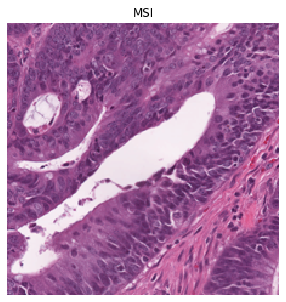

In [17]:
i =5798
print(files[i])
show_image(Image.open(files[i]), title= label_func(files[i]))

In [18]:
splitter = FuncSplitter(lambda o: 'VAL' in o.parent.parent.name)
#splitter = RandomSplitter(valid_pct = 0.5)

#splitter = FuncSplitter(lambda o: ('MSS' in o.parent.parent.name) or ('MSS' in o.parent.name))
#np.random.shuffle(files)
splitter(files)

((#93408) [0,1,2,3,4,5,6,7,8,9...],
 (#98904) [46704,46705,46706,46707,46708,46709,46710,46711,46712,46713...])

## calculate dataset stats (do not use imagenet_stats) 

In [19]:
calculate_stats = False
if calculate_stats:
    dls = spots_datablock.dataloaders(path, bs = 5000)
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)
else: 
    tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
tissue_stats

([0.7700158, 0.6154052, 0.74566764], [0.19486967, 0.26420233, 0.19368471])

In [20]:
#dls = ImageDataLoaders.from_name_func(path, files, label_func)

In [21]:
item_tfms = Resize(224)
aug = aug_transforms(mult=1, flip_vert=True, max_rotate=90., min_zoom=0.9, max_zoom=1.1, 
                     max_lighting=0., max_warp=0., p_affine=0.75, p_lighting=0.,size = 224)
spots_datablock = DataBlock(blocks = (ImageBlock,CategoryBlock( vocab =  ['MSS', 'MSI'], sort = False)),
                  get_items = get_image_files,
                  splitter = splitter,
                  get_y = label_func,        
                  batch_tfms=[Normalize.from_stats(*tissue_stats),*aug]
                  )

In [22]:
dls = spots_datablock.dataloaders(path, bs=2,)


In [23]:
dls.vocab

['MSS', 'MSI']

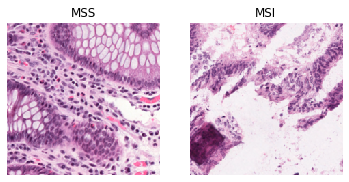

In [24]:
dls.show_batch()

spots_datablock.summary(path)

In [25]:
print (dls[0].tfms)
print (dls[0].after_batch)
bx=dls.one_batch()[0]
print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))

[Pipeline: PILBase.create, Pipeline: label_func -> Categorize -- {'vocab': ['MSS', 'MSI'], 'sort': False, 'add_na': False}]
Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.7700]],

         [[0.6154]],

         [[0.7457]]]], device='cuda:0'), 'std': tensor([[[[0.1949]],

         [[0.2642]],

         [[0.1937]]]], device='cuda:0'), 'axes': (0, 2, 3)}
TensorImage(-3.8691, device='cuda:0') TensorImage(1.4407, device='cuda:0') TensorImage([-0.2512, -0.2435, -0.1794], device='cuda:0') TensorImage([0.7585, 0.7967, 0.7505], device='cuda:0')


In [26]:
Path('models').ls()

(#48) [Path('models/segment_tissue_0.4554598927497864_f_acc_0.8807398080825806.pth'),Path('models/segment_tissue_0.3260129690170288_f_acc_0.900049090385437.pth'),Path('models/segment_tissue_presizing0.4628714621067047_f_acc_0.8756903409957886.pth'),Path('models/segment_tissue_presizing0.34281474351882935_f_acc_0.9168598055839539.pth'),Path('models/segment_tissue_9_class_2.2231385707855225_f_acc_nan.pth'),Path('models/segment_tissue_9_class.pth'),Path('models/pretrained_tissue_aug_0.999517653648182.pth'),Path('models/pretrained_tissue_aug_BAC_epicolon0.9993681800971788.pth'),Path('models/MSI_classifier_epicolon_0.8591032422872864.pth'),Path('models/MSI_classifier_epicolon_level_3_0.8562268910196152.pth')...]

In [27]:
b = dls.one_batch()


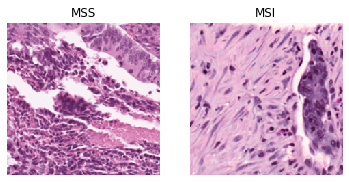

In [28]:

dls.show_batch(b)

In [78]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[error_rate,RocAuc()],normalize=False, n_out=9,
                                  path=Path("."))

pd.options.mode.chained_assignment = None  # default='warn'
tissue = 'TUM'
cls_tissue = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']


tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'
learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model

test_example = True
if test_example: #tissue classification results are not good in TCGA, probably because of magnification and/or color normalization in downloaded tiles 
    #x = torch.randn(2,3,300,300) #two dummy images
    bx = b[0]
    preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=1)(preds), dim = 1)
    #print(preds)
    classes = [cls_tissue[i] for i in preds]
    print(classes[:9])

['ADI', 'STR']


In [79]:
@patch
def accum_values(self:AccumMetric, preds, targs,learn=None):
    "Store targs and preds"
    to_d = learn.to_detach if learn is not None else to_detach
    preds,targs = to_d(preds),to_d(targs)
    keep = targs != -100
    preds,targs = preds[keep],targs[keep]
    if preds.numel() == 0: return
    if self.flatten: preds,targs = flatten_check(preds,targs)
    self.preds.append(preds)
    self.targs.append(targs)

In [80]:
from fastai.fp16_utils import convert_network
class PutYinX(Callback):
    def __init__(self,m_tissue_classifier): 
        self.tissue_classifier = m_tissue_classifier
        self.tissue_classifier.eval().cuda()
    def before_batch(self):
        #self.learn.xb = self.learn.xb[0],self.learn.xb[1], self.learn.xb[1]
        pass
    def after_pred(self):
        if self.learn.y is None: return
        with torch.no_grad():
            tissue_class = convert_network(self.tissue_classifier,x.dtype)(self.x)
        tissue_class = torch.argmax(nn.Softmax(dim=1)(tissue_class), dim = 1)
        def change(t,cond):
            t[cond]=-100
            return t
        self.learn.yb = apply(partial(change,cond=tissue_class <= 1 ),self.learn.yb)

In [81]:
class DropBiasInXY(Callback):
    run_train = False
    def after_pred(self):
        if isinstance(self.learn.pred,tuple) and len(self.learn.pred)>1:
            self.learn.pred = self.learn.pred[0] 
        if isinstance(self.learn.yb,tuple) and len(self.learn.yb)>1:
            self.learn.yb   = (self.learn.yb[0],)
            

In [82]:
class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        self.force_msi = False
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0], 
            ).cuda()
        
        self.msi_classifier = nn.Sequential(
            AdaptiveConcatPool2d(1),
            Flatten(full=False), 
            #nn.AdaptiveAvgPool2d(1),
            #nn.Flatten(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
        
        self.bias_classifier = nn.Sequential(
            AdaptiveConcatPool2d(1),
            Flatten(full=False), 
            #nn.AdaptiveAvgPool2d(1),
            #nn.Flatten(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=False),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=512, out_features=2, bias=False)).cuda()
    
    def forward(self, x, _forward=None):
        if _forward is not None: return getattr(self,_forward)(x)
        
        fe = self.feature_extractor(x)
        pred_msi = self.msi_classifier(fe)
        pred_bias = self.bias_classifier(fe)
        
        if self.force_msi or not self.train: return pred_msi
        
        return (pred_msi, pred_bias)


In [83]:
@patch
def _do_one_batch(self:Learner):
    features = None
    for child in self.model.children():
        for param in child.parameters():
                param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = self.loss_func(self.pred, self.yb[0]); self('after_loss')
    else:
        self.loss = self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 1º training step: MSI-Pred {self.loss}')
    

    for child in self.model.feature_extractor.children():
        for param in child.parameters(): param.requires_grad = False
    #features = self.model.feature_extractor(*self.xb)    
    features = self.model(*self.xb,_forward='feature_extractor')    

    for child in self.model.bias_classifier.children():
        for param in child.parameters(): param.requires_grad = True
    
    #self.pred = self.model.bias_classifier(features);                self('after_pred')
    self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
    cond_target = self.yb[1] #In Hospital target --> 
    cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)
    
    self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 2º training step: Bias-Pred {self.loss}')            
     
        
        
    for child in self.model.feature_extractor.children():
        for param in child.parameters():
                param.requires_grad = True
    for child in self.model.bias_classifier.children():
        for param in child.parameters():
                param.requires_grad = False
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if len(self.yb[1]) == 0: return
    
    #Invert values in Hospital target
    invert_targ = 1 - self.yb[1] 
    invert_targ[self.yb[0] == 0] = -100 ##In Hospital target --> ablate MSS samples (coded 0)
    #-((tanh(2x - 1) + 1) / 2) + 1
    #-(1 / (1 + ℯ^(-(4x - 2)))) + 1
    self.loss = - self.loss_func(self.pred[1], cond_target); self('after_loss')
    if not self.training: return
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    print(f'finished 3º training step: Bias-Distillator {self.loss}')

In [84]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [85]:
tissue_backbone = True
if tissue_backbone: 
    x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    y = m(x)
    print(y)
    test_eq(y[0].shape, [2, 2])
    learn = Learner(dls, m, metrics=[error_rate,RocAucBinary()], loss_func = CrossEntropyLossFlat(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [DropBiasInXY(),SaveModelCallback(monitor='roc_auc_score')])
                   #)#,  

else: 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

(tensor([[-1.1464,  0.1181],
        [ 0.6246, -0.0859]], device='cuda:0', grad_fn=<MmBackward>), tensor([[-0.0980,  0.8466],
        [ 1.0970, -0.4671]], device='cuda:0', grad_fn=<MmBackward>))


In [86]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : [DropBiasInXY]
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallbac

In [87]:
learn.to_fp16()

In [88]:
train = False

In [89]:
if train:
    learn.fit_one_cycle(10,1e-5)

In [90]:
if train:
    #learn.fine_tune(20)
    auc_val = learn.final_record[3]
    learn.save(f'MSI_classifier_TissueBackbone_TCGA_BiasDistilled_level_{zoom_filter}_TUM_{auc_val}' )
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    #learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902') #AUC test = 0.59
    learn.load('no_mazenko/models/MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_None_TUM_0.8848650115631501') #AUC test = 0.71
    #learn.load('MSI_classifier_TissueBackbone_Corr_Loss_Macenko_epicolon_BiasDistilled_level_None_TUM_0.8370522891634157') #AUC test = 0.62

Could not load the optimizer state.


In [91]:
preds, targs, decoded, losses = learn.get_preds(dl=dls[1], with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1))
#preds, targs, decoded, losses = learn.get_preds(dl=new_dl, with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1), reorder = False)


In [92]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(preds_val.shape)

torch.Size([98904])


In [93]:
decoded, targs, losses, preds

(TensorImage([0, 1, 0,  ..., 0, 0, 0]),
 TensorCategory([1, 1, 1,  ..., 0, 0, 0]),
 TensorImage([1.2395e+01, 2.5395e-01, 7.4908e+00,  ..., 5.7355e-03, 2.0761e-02,
         1.1503e-04]),
 TensorImage([[1.0000e+00, 4.1412e-06],
         [2.2427e-01, 7.7573e-01],
         [9.9944e-01, 5.5820e-04],
         ...,
         [9.9428e-01, 5.7191e-03],
         [9.7945e-01, 2.0547e-02],
         [9.9988e-01, 1.1502e-04]]))

In [94]:
print(preds.shape, targs.shape, losses.shape)

torch.Size([98904, 2]) torch.Size([98904]) torch.Size([98904])


In [95]:
np.array(decoded).mean(), np.array(targs).mean(),

(0.13800250748200274, 0.2864899296287309)

In [96]:
preds = preds[targs >= 0]
losses = losses[targs >= 0]
decoded = decoded[targs >= 0]
targs = targs[targs >= 0]


auc = 0.6877636796901222, best threshold = 0.27776899933815


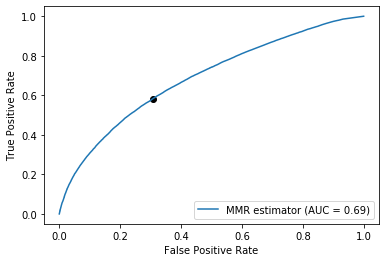

In [97]:
t = targs.cpu().numpy() #MSS is labeled as 0, MSI as 1
p = preds.float().softmax(dim=-1).cpu()[...,-1]
fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [98]:
precision, recall, thresholds = metrics.precision_recall_curve(t,p)

In [99]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] == 0.5]

array([[0.57035084, 0.27481913, 0.5       ]])

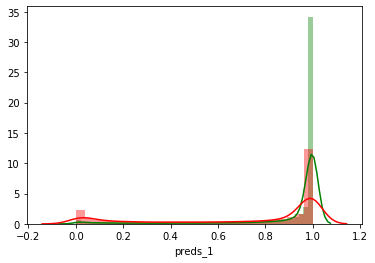

In [100]:
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs, losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [101]:
targs.cpu().numpy(), preds.float().softmax(dim=-1).cpu()

(array([1, 1, 1, ..., 0, 0, 0]),
 TensorImage([[0.7311, 0.2689],
         [0.3655, 0.6345],
         [0.7308, 0.2692],
         ...,
         [0.7288, 0.2712],
         [0.7229, 0.2771],
         [0.7310, 0.2690]]))

In [125]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs.cpu().numpy(), decoded.cpu())

array([[64706,  5863],
       [20549,  7786]])

In [126]:
tn, fp, fn, tp = skm.confusion_matrix(targs.cpu().numpy(), decoded.cpu()).ravel()
print(tn, fp, fn, tp)

64706 5863 20549 7786


In [103]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh
best_decoded

TensorImage([False,  True, False,  ..., False, False, False])

In [104]:
skm.confusion_matrix(targs.cpu().numpy(), best_decoded)

array([[48875, 21694],
       [11807, 16528]])

### Agregate prediction by patient

In [105]:

cx['targets'] = cx.apply(lambda o: 1 if (o.MSIStatus == 'MSI-H') else  0,  1)
cx[['MSIStatus', 'submitter_id', 'targets']]

,MSIStatus,submitter_id,targets
case_id,,,
a94e1279-a975-480a-93e9-7b1ff05cbcbf,MSS,TCGA-3L-AA1B,0
92554413-9ebc-4354-8e1b-9682f3a031d9,MSS,TCGA-4N-A93T,0
a5e14add-1552-4606-9ffe-3a03bcf76640,NaN,TCGA-4T-AA8H,0
1136dd50-242a-4659-aad4-c53f9e759bb3,MSS,TCGA-5M-AAT4,0
515a062e-f68e-4100-a923-bd2ce0bbe071,MSI-L,TCGA-5M-AAT5,0
...,...,...,...
3ccbe7c7-c779-4a98-b495-ff020d3e9e55,MSS,TCGA-VQ-AA6I,0
a267ddb4-b2d9-4292-b120-6e13e70d01f8,MSS,TCGA-VQ-AA6J,0
83a0f9ef-4bf0-4efe-8713-f8b6ab4f5773,MSS,TCGA-VQ-AA6K,0


In [106]:
targets_df = cx.set_index('submitter_id')
targets_df 


,project_id,gender,race,primary_diagnosis,tumor_stage,age_at_diagnosis,vital_status_TUM_clini,morphology,days_to_death,days_to_recurrence,tumor_grade,tissue_or_organ_of_origin,days_to_birth,progression_or_recurrence,site_of_resection_or_biopsy,days_to_last_follow_up,hasDied,cleanStage,Var1,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status_GIT_extraClini,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS_time,DSS,DSS_time,DFI,DFI_time,PFI,PFI_time,Redaction,TCGAParticipantBarcode,TCGAProjectCode,Organ,PathologicT,PathologicN,PathologicM,PathologicStage,Country,Gender2,AgeAtInitialPathologicDiagnosis,DaysToLastKnownAlive,VitalStatus,DetailedAnatomicSite,MSIStatus,Race3,GeographicRegion,LeukocyteFraction,CDKN2AMethylation,MLH1Methylation,BRCA1EpigeneticSilencing,RAD51C_epigenetic_silencing,TCellsCD8,NKCellsResting,MacrophagesM1,StemnessRNABased,StemnessDNAmethBased,ColorectalCMS,InterferonGammaResponse_C1Hallmark,WntBetaCateningSignaling_C1Hallmark,AnatomicRegion,LeftOrRightColon,Stage,HypermethylationCategory,GastricHistologicalClassification,SNPArrayTCGAAliquotID,...,MS_frac_stage1_MSI_1,MS_frac_stage1_MSI_2,MS_frac_stage1_POLE_1,MS_frac_stage1_POLE_2,MS_frac_stage1_AAtoAC,MS_frac_stage1_residual,MS_stage2_BRCA,MS_stage2_APOBEC_1,MS_stage2_APOBEC_2,MS_stage2_AAtoAC,MS_stage2_CpGtoT,MS_frac_stage2_BRCA,MS_frac_stage2_APOBEC_1,MS_frac_stage2_APOBEC_2,MS_frac_stage2_AAtoAC,MS_frac_stage2_CpGtoT,n_silent,n_nonsilent,n_indel,SNVMutationDensity,IndelMutationDensity,MutationDensity,Hypermutated,arm_CN_1p,arm_CN_1q,arm_CN_2p,arm_CN_2q,arm_CN_3p,arm_CN_3q,arm_CN_4p,arm_CN_4q,arm_CN_5p,arm_CN_5q,arm_CN_6p,arm_CN_6q,arm_CN_7p,arm_CN_7q,arm_CN_8p,arm_CN_8q,arm_CN_9p,arm_CN_9q,arm_CN_10p,arm_CN_10q,arm_CN_11p,arm_CN_11q,arm_CN_12p,arm_CN_12q,arm_CN_13q,arm_CN_14q,arm_CN_15q,arm_CN_16p,arm_CN_16q,arm_CN_17p,arm_CN_17q,arm_CN_18p,arm_CN_18q,arm_CN_19p,arm_CN_19q,arm_CN_20p,arm_CN_20q,arm_CN_21q,arm_CN_22q,TCGA_Barcode,Cancer,Tota_Mutation_cnt,MSIscore,POLE,MLH1,MLH3,MGMT,MSH6,MSH3,MSH2,PMS1,PMS2,POLE_loc,MLH1_loc,MLH3_loc,MGMT_loc,MSH6_loc,MSH3_loc,MSH2_loc,PMS1_loc,PMS2_loc,targets
submitter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-3L-AA1B,TCGA-COAD,female,black or african american,C18.0,stage i,22379,alive,8140/3,NaN,NaN,NaN,C18.0,-22379,NaN,C18.0,475.0,False,1.0,1954.0,TCGA-3L-AA1B,COAD,61.0,Stage I,[Not Applicable],Colon Adenocarcinoma,[Not Available],2013.0,[Not Available],-22379.0,Alive,TUMOR FREE,475.0,NaN,[Not Available],NaN,NaN,NaN,NaN,Complete Remission/Response,NaN,NaN,0.0,475.0,0.0,475.0,0.0,475.0,0.0,475.0,NaN,TCGA-3L-AA1B,COAD,COAD,T2,N0,M0,I,United_States,FEMALE,61.27,475.0,Alive,Cecum,MSS,BLACK OR AFRICAN AMERICAN,The_Americas,0.294204,1.0,0.0,0.0,0.0,0.067693,0.096849,0.013252,0.396243,0.15767,NaN,-0.469581,5.115828,Ascending_Colon,Right,I,CRC CIMP-L,NaN,TCGA-3L-AA1B-01A-11D-A36W-01,...,0.097712,0.000000,0.065694,0.060483,0.000000,0.313838,4.3087,2.1440,4.14130,0.00000,167.3836,0.024209,0.012046,0.023268,0.000000,0.94048,48.0,103.0,2.0,4.199510,0.062065,4.261575,0.0,0.000,0.000,0.598,0.598,0.000,0.000,0.639,0.000,0.633,0.633,0.000,0.000,1.433,1.433,0.677,0.677,0.000,0.000,0.000,0.000,0.000,0.00,0.643,0.643,0.704,0.000,0.614,0.000,0.000,-0.661,0.058,-0.717,-0.717,0.000,0.000,1.460,1.460,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
TCGA-4N-A93T,TCGA-COAD,male,black or african american,C18.2,stage iiib,24523,alive,8140/3,NaN,NaN,NaN,C18.2,-24523,NaN,C18.2,146.0,False,3.0,1955.0,TCGA-4N-A93T,COAD,67.0,Stage I

In [107]:
files_df = pd.DataFrame()
files_df['path'] = files

In [108]:
files_df['valid'] = files_df.path.apply(lambda o: 1 if re.search(r'_VAL', o.parent.parent.name)  else 0)
files_df['submitter_id'] = files_df.path.apply(lambda o: re.search(r'TCGA-\w{2}-\w{4}', o.name)[0])

In [109]:
files_df['pred'] = None


In [110]:
files_df

,path,valid,submitter_id,pred
0,TCGA/TILES/MSIMUT/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.png,0,TCGA-CM-4746,None
1,TCGA/TILES/MSIMUT/blk-AAADTPTGAKQV-TCGA-A6-3809-01Z-00-DX1.png,0,TCGA-A6-3809,None
2,TCGA/TILES/MSIMUT/blk-AAAFQELPMPTI-TCGA-AA-3715-01Z-00-DX1.png,0,TCGA-AA-3715,None
3,TCGA/TILES/MSIMUT/blk-AAAGNSGLEPNP-TCGA-CM-4746-01Z-00-DX1.png,0,TCGA-CM-4746,None
4,TCGA/TILES/MSIMUT/blk-AAAHDPKQAIIV-TCGA-CK-5913-01Z-00-DX1.png,0,TCGA-CK-5913,None
...,...,...,...,...
192307,TCGA/TILES/MSS_VAL/MSS/blk-YYYQNFFCQMAT-TCGA-AY-A71X-01Z-00-DX1.png,1,TCGA-AY-A71X,None
192308,TCGA/TILES/MSS_VAL/MSS/blk-YYYRLVSSDSDW-TCGA-EI-6514-01Z-00-DX1.png,1,TCGA-EI-6514,None
192309,TCGA/TILES/MSS_VAL/MSS/blk-YYYTITTWRNGD-TCGA-F4-6460-01Z-00-DX1.png,1,TCGA-F4-6460,None
192310,TCGA/TILES/MSS_VAL/MSS/blk-YYYVCAPMQNDQ-TCGA-NH-A50T-01Z-00-DX1.png,1,TCGA-NH-A50T,None


[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1] [0.42645375 0.33164243 0.30779358 0.35239514 0.34006104 0.50971431
 0.31814187 0.26911544 0.28558089 0.26923837 0.27216847 0.28199713
 0.2703403  0.26895669 0.26896953 0.27169941 0.27152867 0.27786056
 0.28614256 0.33268479 0.2720197  0.27036066 0.28813159 0.31608331
 0.34348191 0.37469655 0.50863677 0.39467509 0.37330252 0.28005376
 0.29547653 0.29504155 0.2747481  0.26923103 0.27277228 0.2712796
 0.27356452 0.2710786  0.26968197 0.28227208 0.27835624 0.27358022
 0.27626082 0.2689791  0.31912152 0.33168063 0.32729613 0.31802996
 0.31334061 0.42316298 0.35171451 0.40334284 0.28517884 0.32930175
 0.38108696 0.38858305 0.32206846 0.30288739 0.28463427 0.36007674
 0.2857404  0.3277657  0.30326293 0.27124755 0.57186833 0.28352145
 0.31340052 0.35004714 0.31239643 0.35842918 0.28956312 0.59

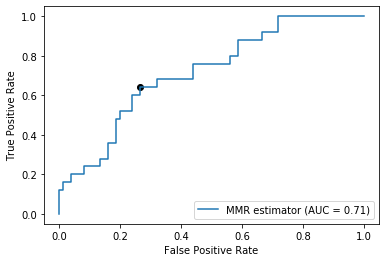

In [111]:
#copy preds following the order in files
files_df.loc[files_df.valid == 1, 'preds'] = np.array(preds_val)

_preds = files_df.loc[(files_df.valid == 1)  ].groupby('submitter_id').preds.mean().values
keys = files_df.loc[(files_df.valid == 1)  ].groupby('submitter_id').groups.keys()
_targs =  targets_df.loc[keys].targets.values

#_preds = _preds[_targs >= 0]

#_targs = _targs[_targs >= 0]
print(_targs,_preds)

t = _targs #MSS is labeled as 0, MSI as 1
p = _preds
fpr, tpr, thresholds = skm.roc_curve(_targs,_preds)
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [112]:
_best_decoded = _preds >= best_thresh
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(_targs
                     , _best_decoded)

array([[55, 20],
       [ 9, 16]])

# SHAP

In [113]:
import shap

In [114]:
b=learn.dls[1].one_batch()

In [115]:
b[0].shape

torch.Size([2, 3, 224, 224])

In [116]:
learn.model.force_msi = True
out = learn.model.eval()(b[0][0:2])
out


TensorImage([[ 5.2855, -7.1125],
        [-1.5182, -0.2763]], device='cuda:0', grad_fn=<AliasBackward>)

In [117]:
preds = Tensor(out.cpu().detach().numpy())
preds = preds.float().softmax(dim=-1).cpu()
preds

tensor([[1.0000e+00, 4.1269e-06],
        [2.2410e-01, 7.7590e-01]])

In [118]:
xb=Tensor(b[0].cpu()).cuda()

In [119]:
learn.model.force_msi = True
e=shap.DeepExplainer(learn.model,xb[:100])

In [120]:
yb= b[1].cpu()
test_labels = np.array(yb[0:2])
test_labels

array([1, 1])

In [121]:
test_images=xb[0:2]
shap_values = e.shap_values(test_images)

In [122]:
denorm = lambda t:Normalize.from_stats(*tissue_stats).decodes(TensorImage(t))

In [123]:
shap_numpy = [np.swapaxes(np.swapaxes(denorm(s), 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(denorm(test_images).cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

(2, 224, 224, 3)

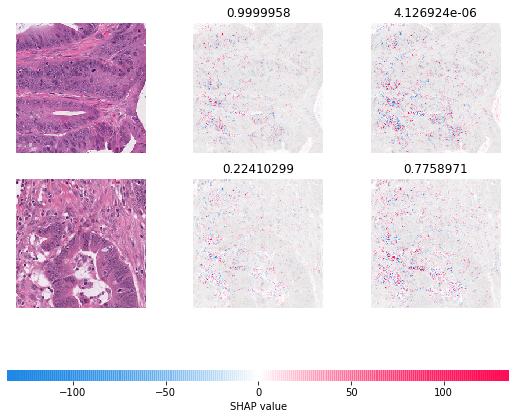

In [124]:
shap.image_plot(shap_numpy, test_numpy, labels= preds)